In [1]:
import holidays
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

In [2]:
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

def fit_mape_linear_model(X, y):

    def mape_loss(beta, X, y):
        y_pred = X @ beta
        return np.mean(np.abs(y - y_pred) / y) * 100


    X = np.asarray(X)
    y = np.asarray(y).squeeze()

    # Include bias term
    X = np.column_stack((np.ones(X.shape[0]), X))

    # Initial guess for the parameters
    init_params = np.zeros(X.shape[1])

    # Minimize the MAPE loss
    result = minimize(mape_loss, init_params, args=(X, y), method='L-BFGS-B')

    # Extract optimized parameters
    beta_opt = result.x


    # Initialise and return LR model
    model = LinearRegression()
    model.coef_ = beta_opt[1:]
    model.intercept_ = beta_opt[0]

    return model

In [3]:
train = pd.read_csv('data/train.csv', parse_dates=['date'])
test = pd.read_csv('data/train.csv', parse_dates=['date'])

train = train.dropna().reset_index(drop=True)
df = pd.concat([train, test], sort=False).reset_index(drop=True)
df.head()

,id,date,country,store,product,num_sold
0,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
1,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
2,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
3,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
4,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0


# Feature Engineering

### Useful Columns

In [4]:
df['year'] = df['date'].dt.year
df['n_day'] = (df['date'] - df['date'].min()).dt.days
df['weekday'] = df['date'].dt.weekday
df['day_of_year'] = df['date'].dt.dayofyear

# Generate Wave Columns
wave_cols = []

# Subtract leap dates
df.loc[df['date'] > dt.datetime(2012, 2, 29), 'n_day'] -= 1
df.loc[df['date'] > dt.datetime(2016, 2, 29), 'n_day'] -= 1

for i in range(1, 10):
    df[f'wave_sin{i}'] = np.sin(np.pi * i * df['n_day'] / 365)
    df[f'wave_cos{i}'] = np.cos(np.pi * i * df['n_day'] / 365)
    
    wave_cols.append(f'wave_sin{i}')
    wave_cols.append(f'wave_cos{i}')


# Near Holiday
df['near_holiday'] = 0
for country in df['country'].unique():
    days = [day for day in holidays.CountryHoliday(country, years=df['year'].unique())]
    for day in days:
        df.loc[(df.country == country) & 
                (df['date'].dt.date < day + dt.timedelta(days=10)) & 
                (df['date'].dt.date > day - dt.timedelta(days=10)), 'near_holiday'] = 1

In [5]:
df.head()

,id,date,country,store,product,num_sold,year,n_day,weekday,day_of_year,...,wave_cos5,wave_sin6,wave_cos6,wave_sin7,wave_cos7,wave_sin8,wave_cos8,wave_sin9,wave_cos9,near_holiday
0,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010,0,4,1,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1
1,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,0,4,1,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1
2,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010,0,4,1,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1
3,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,0,4,1,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1
4,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0,2010,0,4,1,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1


## Decomposition

### GDP Factor

In [6]:
import requests

def get_gdp_per_capita(country, year):
    alpha3 = {
        'Canada': 'CAN',
        'Finland': 'FIN',
        'Italy': 'ITA',
        'Kenya': 'KEN',
        'Norway': 'NOR',
        'Singapore': 'SGP'
    }

    url="https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json".format(alpha3[country], year)
    response = requests.get(url).json()

    return response[1][0]['value']

gdp = np.array([[get_gdp_per_capita(country, year) for year in df['year'].unique()] for country in df['country'].unique()])
gdp_df = pd.DataFrame(gdp, columns=df['year'].unique(), index=df['country'].unique())

for year in df['year'].unique():
    for country in df['country'].unique():
        df.loc[(df['year'] == year) & (df['country'] == country), 'gdp'] = gdp_df.loc[country, year]

In [7]:
df['gdp_factor'] =  (-17643.346899+85.42355636*df['gdp']) / 365

In [8]:
gdp_df.head()

,2010,2011,2012,2013,2014,2015,2016
Canada,47560.666601,52223.858840,52670.344734,52638.118724,50960.843117,43594.194105,42314.061582
Finland,46506.291902,51060.324259,47551.674084,49691.014520,50073.776082,42560.345677,43451.256244
Italy,36184.711870,38851.388134,35235.798906,35747.707953,35750.719750,30387.129319,31126.324695
Kenya,1091.518731,1096.144998,1285.005362,1370.878852,1482.815663,1489.119598,1554.126103
Norway,88163.208593,101221.813477,102175.919298,103553.840134,97666.695184,74809.965805,70867.360997


In [9]:
grouped_data = df.groupby(['date', 'year', 'country'])['num_sold'].sum().reset_index()

total_per_day = df.groupby('year')['num_sold'].sum().reset_index()

grouped_data = grouped_data.merge(total_per_day, on=['year'], suffixes=['', '_total']).reset_index()
grouped_data = grouped_data.merge(df[['date', 'country', 'gdp_factor']], on=['date', 'country'])

grouped_data.head()

,index,date,year,country,num_sold,num_sold_total,gdp_factor
0,0,2010-01-01,2010,Canada,30198.0,44268786.0,11082.624485
1,0,2010-01-01,2010,Canada,30198.0,44268786.0,11082.624485
2,0,2010-01-01,2010,Canada,30198.0,44268786.0,11082.624485
3,0,2010-01-01,2010,Canada,30198.0,44268786.0,11082.624485
4,0,2010-01-01,2010,Canada,30198.0,44268786.0,11082.624485


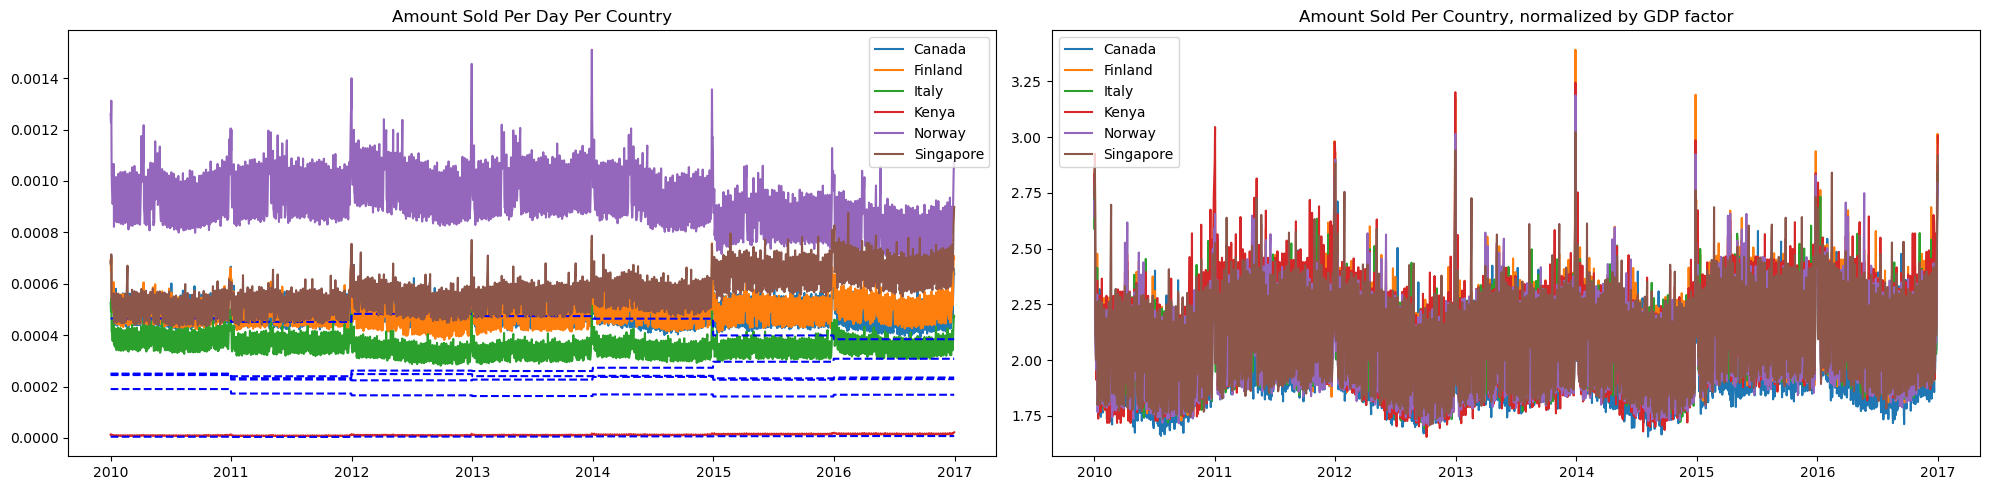

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Plotting ratio of daily sale to yearly total, per country
for country in df['country'].unique():
    country_data = grouped_data[((grouped_data['country'] == country) & (grouped_data['date'] < dt.datetime(2017, 1, 1)))]

    axs[0].plot(country_data['date'], country_data['num_sold'] / country_data['num_sold_total'], '-', label=country)
    axs[0].plot(country_data['date'], country_data['gdp_factor'] / country_data['num_sold_total'], 'b--')

axs[0].set_title('Amount Sold Per Day Per Country')
axs[0].legend()


for country in df['country'].unique():
    country_data = grouped_data[((grouped_data['country'] == country) & (grouped_data['date'] < dt.datetime(2017, 1, 1)))]

    axs[1].plot(country_data['date'], country_data['num_sold'] / country_data['gdp_factor'], '-', label=country)
    
axs[1].set_title('Amount Sold Per Country, normalized by GDP factor')
axs[1].legend()

df['ratio'] = df['gdp_factor']
df['total'] = df['num_sold'] / df['ratio']

plt.tight_layout()
plt.show()

### Store Factor

Store factor sum is 1.0


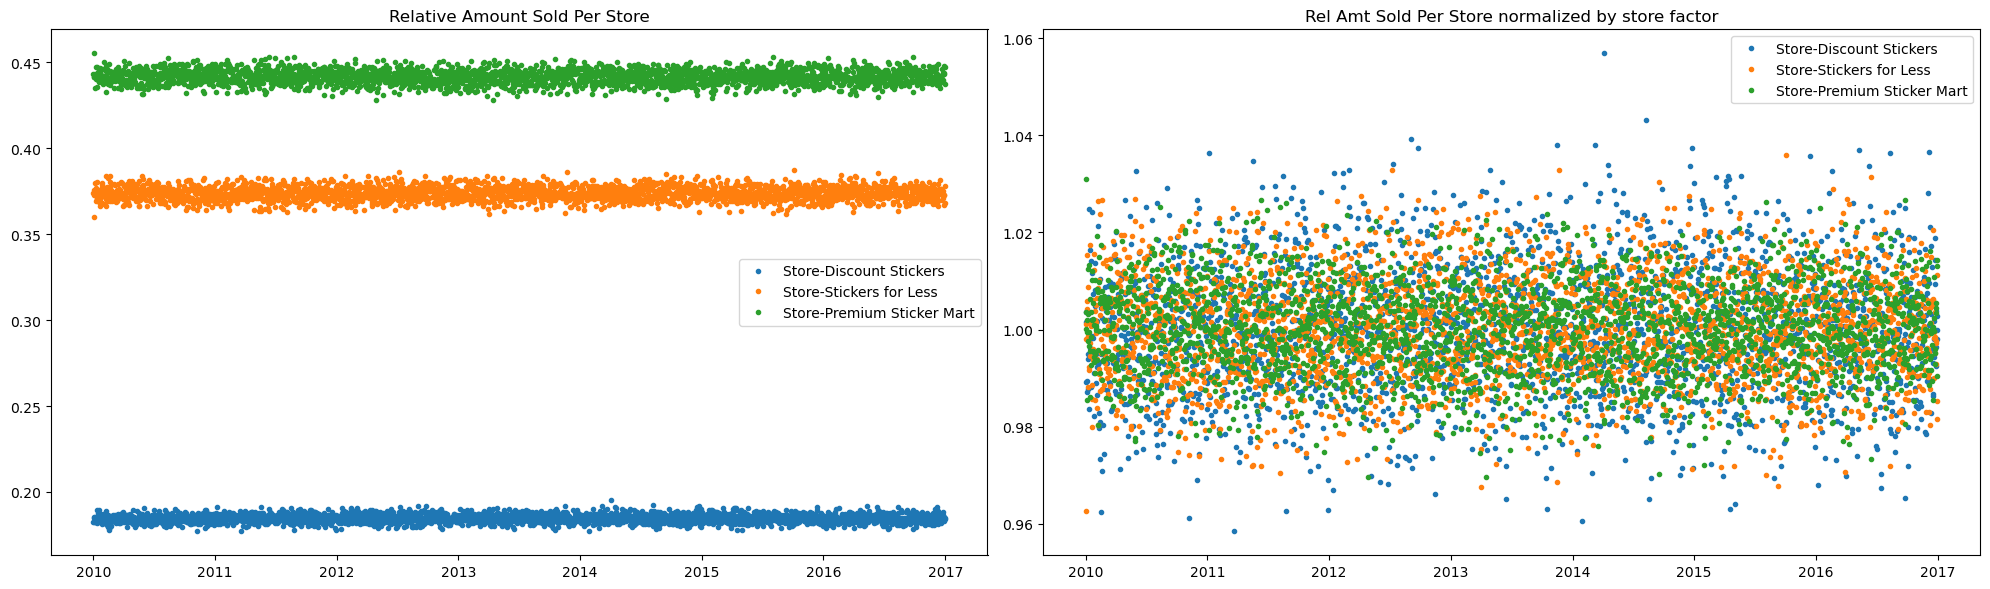

In [11]:
df_no_can_ken = df[~df['country'].isin(['Canada', 'Kenya'])]

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

store_data = df_no_can_ken.groupby(['date', 'store'])['num_sold'].sum().reset_index()
total_per_day = df_no_can_ken.groupby('date')['num_sold'].sum().reset_index()

store_data = store_data.merge(total_per_day, on=['date'], suffixes=['', '_total'])


# Calculate store factor
store_data['store_factor'] = store_data['num_sold'] / store_data['num_sold_total']
store_df = store_data.groupby('store')['store_factor'].mean().reset_index()

store_data.drop('store_factor', axis=1, inplace=True)
store_data = store_data.merge(store_df, on=['store'])

print(f"Store factor sum is {store_df['store_factor'].sum()}")


# Merge store factor into df
df = df.drop('store_factor', axis=1, errors='ignore')
df = df.merge(store_df, on=['store'])
df['ratio'] = df['store_factor']


for store in df['store'].unique():
    data = store_data[store_data['store'] == store]
    axs[0].plot(data['date'], data['num_sold'] / data['num_sold_total'], '.', label=f'Store-{store}')

axs[0].set_title('Relative Amount Sold Per Store')
axs[0].legend()


# Normalize by current ratio
for store in df['store'].unique():
    data = store_data[store_data['store'] == store]
    axs[1].plot(data['date'], data['num_sold'] /  data['num_sold_total'] /  data['store_factor'], '.', label=f'Store-{store}')

axs[1].set_title('Rel Amt Sold Per Store normalized by store factor') 
axs[1].legend()

plt.tight_layout()
plt.show()

### Product Factor (GDP Factor * Store Factor)

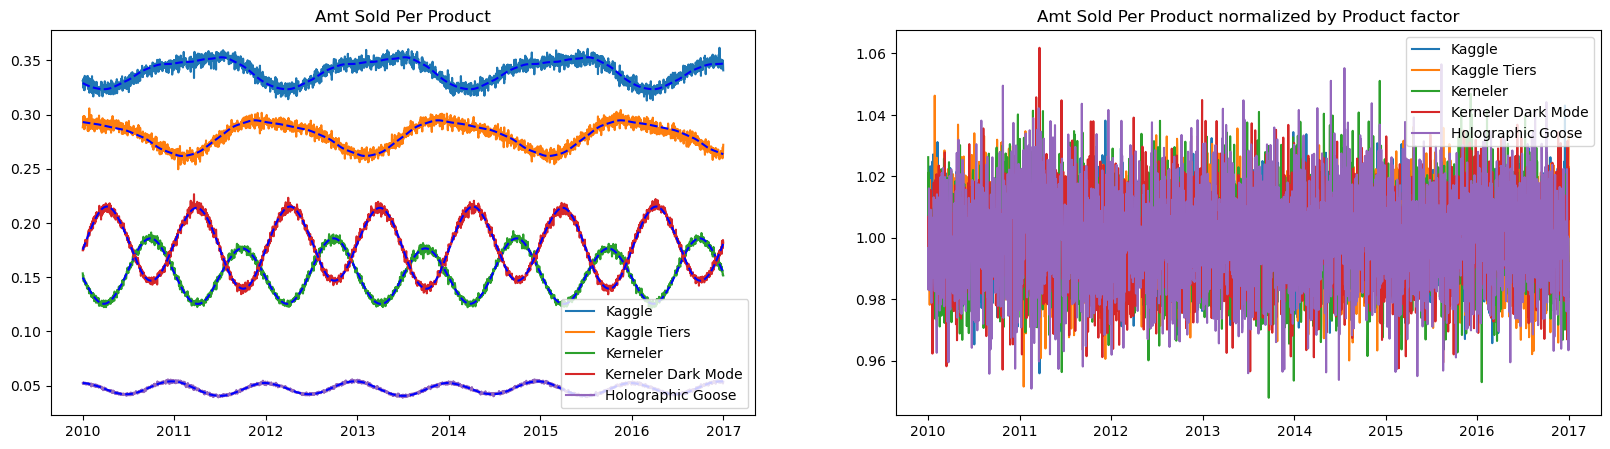

In [12]:
df['ratio'] = df['store_factor'] * df['gdp_factor']
df['total'] = df['num_sold'] / df['ratio']

df_no_can_ken = df[~df['country'].isin(['Canada', 'Kenya'])]
total_per_day = df_no_can_ken.groupby('date')['total'].sum().reset_index()

df_no_can_ken = df_no_can_ken.merge(total_per_day, on=['date'], suffixes=['', '_per_day'])
df_no_can_ken['total_perc_per_day'] = df_no_can_ken['total'] / df_no_can_ken['total_per_day'] 

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# fit wave columns to each product
df['product_factor'] = None
for product in df['product'].unique():

    df_product = df_no_can_ken[((df_no_can_ken['product'] == product) & (df_no_can_ken['date'] < dt.datetime(2017, 1, 1)))].groupby('date')
    X = df_product[wave_cols].mean()
    y = df_product['total_perc_per_day'].sum()
    
    model = fit_mape_linear_model(X, y)
    df.loc[df['product'] == product, 'product_factor'] = model.predict(df[df['product'] == product][wave_cols].values)

    axs[0].plot(df_product['date'].unique().index, y, '-', label=product)
    axs[0].plot(df_product['date'].unique().index, model.predict(X.values), 'b--')

axs[0].set_title('Amt Sold Per Product')
axs[0].legend()


# Visualize the result
df_no_can_ken = df[~df['country'].isin(['Canada', 'Kenya'])]
total_per_day = df_no_can_ken.groupby('date')['total'].sum().reset_index()

df_no_can_ken = df_no_can_ken.merge(total_per_day, on=['date'], suffixes=['', '_per_day'])
df_no_can_ken['total_perc_per_day'] = df_no_can_ken['total'] / df_no_can_ken['total_per_day'] 

for product in df['product'].unique():
    df_product = df_no_can_ken[((df_no_can_ken['product'] == product) & (df_no_can_ken['date'] < dt.datetime(2017, 1, 1)))].groupby('date')

    y = df_product['total_perc_per_day'].sum()
    product_factor = df_product['product_factor'].mean()

    axs[1].plot(df_product['date'].unique().index, y / product_factor, '-', label=product)
    
axs[1].set_title('Amt Sold Per Product normalized by Product factor')
axs[1].legend()

df['ratio'] = df['store_factor'] * df['gdp_factor'] * df['product_factor']
df['total'] = df['num_sold'] / df['ratio']

### Day of Week Factor

Text(0.5, 1.0, 'Mean Total Per Day normalized by weekday factor')

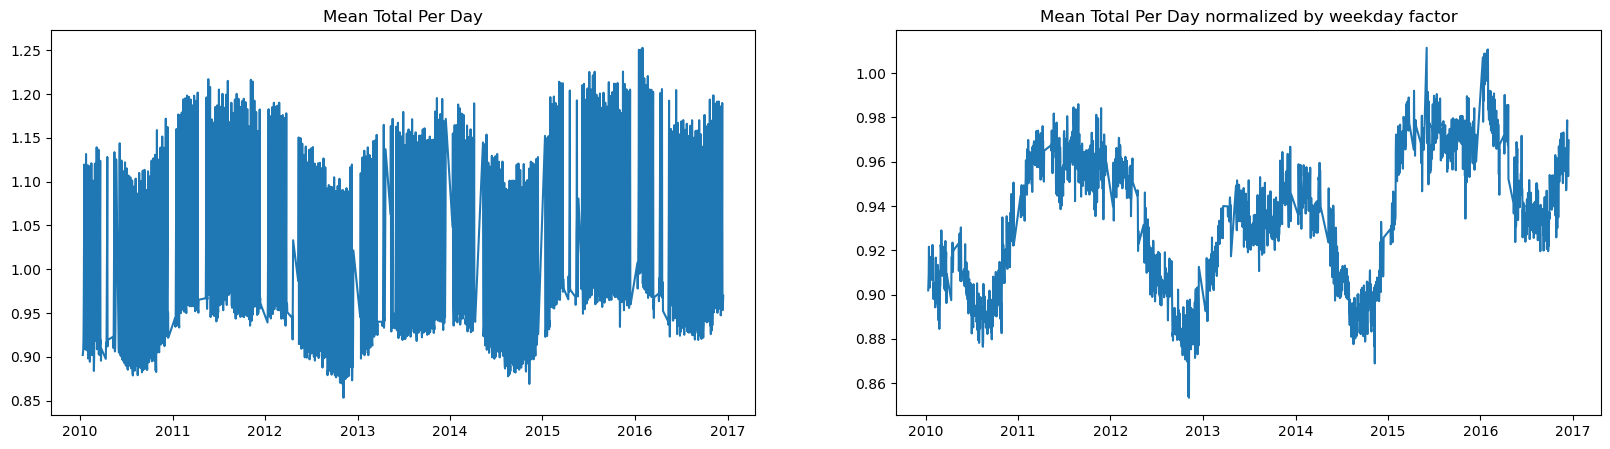

In [13]:
df['ratio'] = df['store_factor'] * df['gdp_factor'] * df['product_factor']
df['total'] = df['num_sold'] / df['ratio']

df_no_can_ken_hol = df[~((df['country'].isin(['Canada', 'Kenya'])) | (df['near_holiday']))]

mean_per_weekday = df_no_can_ken_hol.groupby('weekday')['total'].mean().reset_index()
mean_mon_thur = mean_per_weekday[mean_per_weekday['weekday'] < 4]['total'].mean()
ratio_per_weekday = mean_per_weekday.copy()
ratio_per_weekday['day_of_week_factor'] = ratio_per_weekday['total'] / mean_mon_thur
ratio_per_weekday = ratio_per_weekday.drop('total', axis=1)

df = df.drop('day_of_week_factor', axis=1, errors='ignore')
df = df.merge(ratio_per_weekday, on='weekday')

grouped_data = df_no_can_ken_hol.groupby(['date'])['total'].mean().reset_index()
grouped_data = grouped_data[grouped_data['date'] < dt.datetime(2017, 1, 1)]

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].plot(grouped_data['date'], grouped_data['total'], '-')
axs[0].set_title('Mean Total Per Day')

df['ratio'] = df['store_factor'] * df['gdp_factor'] * df['product_factor'] * df['day_of_week_factor']
df['total'] = df['num_sold'] / df['ratio']

# Visualize the result
df_no_can_ken_hol = df[~((df['country'].isin(['Canada', 'Kenya'])) | (df['near_holiday']))]

grouped_data = df_no_can_ken_hol.groupby(['date'])['total'].mean().reset_index()
grouped_data = grouped_data[grouped_data['date'] < dt.datetime(2017, 1, 1)]

axs[1].plot(grouped_data['date'], grouped_data['total'], '-')
axs[1].set_title('Mean Total Per Day normalized by weekday factor')

## Sincos Factor

c:\Users\yashs\miniconda3\envs\eda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\yashs\miniconda3\envs\eda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Text(0.5, 1.0, 'Mean Total Per Day normalized by sincos factor')

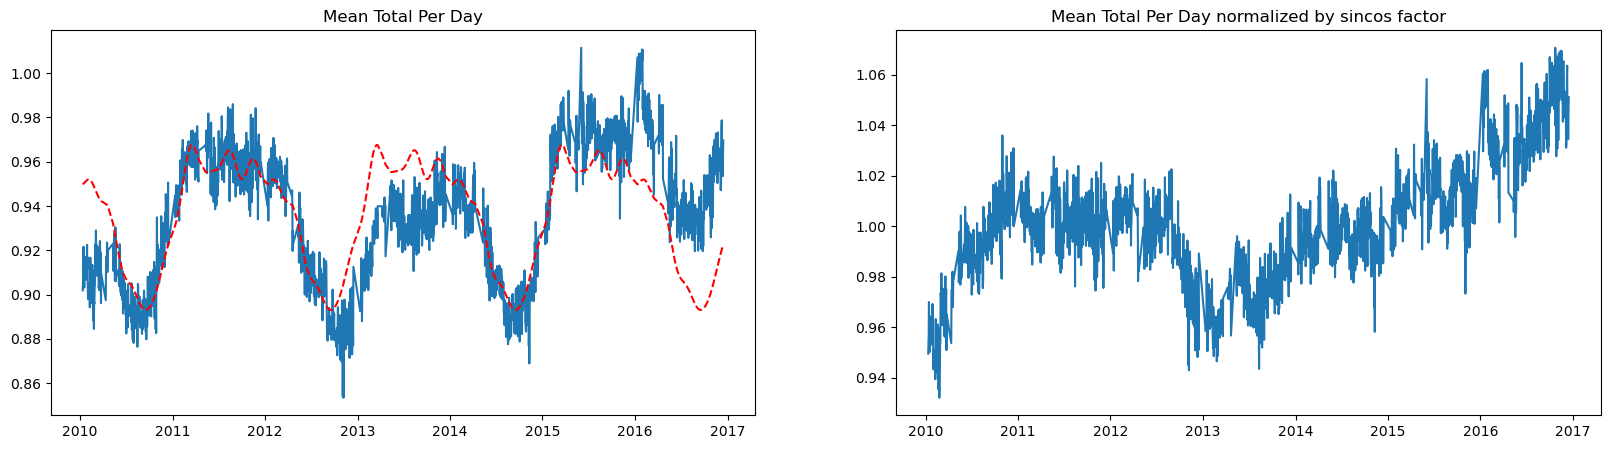

In [15]:
df['ratio'] = df['store_factor'] * df['gdp_factor'] * df['product_factor'] * df['day_of_week_factor']
df['total'] = df['num_sold'] / df['ratio']

df_no_can_ken_hol = df[~((df['country'].isin(['Canada', 'Kenya'])) | (df['near_holiday']))]
grouped_data = df_no_can_ken_hol[df_no_can_ken_hol['date'] < dt.datetime(2017, 1, 1)].groupby(['date'])
X = grouped_data[wave_cols].mean()
y = grouped_data['total'].mean()

model = fit_mape_linear_model(X, y)

df['sincos_factor'] = model.predict(df[wave_cols])

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].plot(grouped_data['date'].unique().index, y, '-')
axs[0].set_title('Mean Total Per Day')
axs[0].plot(grouped_data['date'].unique().index, model.predict(X), 'r--')


df['ratio'] = df['store_factor'] * df['gdp_factor'] * df['product_factor'] * df['day_of_week_factor'] * df['sincos_factor']
df['total'] = df['num_sold'] / df['ratio']

# Visualize the result
df_no_can_ken_hol = df[~((df['country'].isin(['Canada', 'Kenya'])) | (df['near_holiday']))]
grouped_data = df_no_can_ken_hol.groupby(['date'])['total'].mean().reset_index()

axs[1].plot(grouped_data['date'], grouped_data['total'], '-')
axs[1].set_title('Mean Total Per Day normalized by sincos factor')

## Trend Factor

This factor is only meant to make calculating the subsequent factors easier.

I attempted to include this factor in the final product for one of my submissions. Doing this while also removing the 1.06 factor (see const_factor under the "Prediction and Submission" section) resulted in my best public LB score (0.04422). However, as expected, this was very overfit (private LB ~0.054).

Text(0.5, 1.0, 'Mean Total Over Time Corrected by Trend Factor')

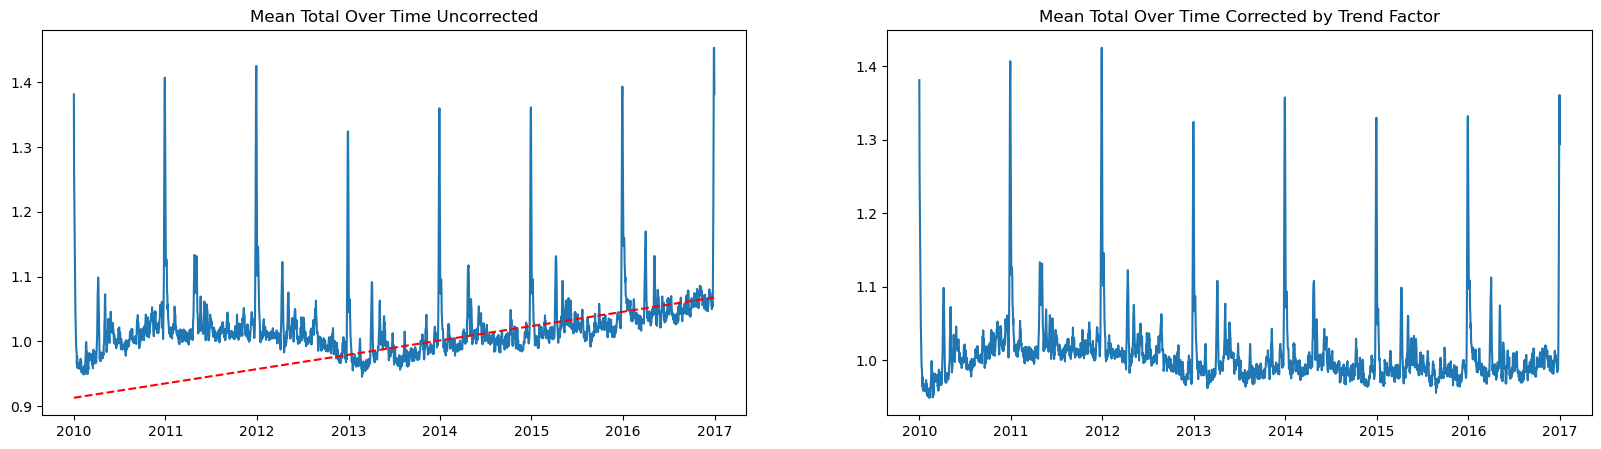

In [16]:
df['ratio'] = df['store_factor'] * df['gdp_factor'] * df['product_factor'] * df['day_of_week_factor'] * df['sincos_factor']
df['total'] = df['num_sold'] / df['ratio']

grouped_data = df.groupby(['date', 'n_day'])['total'].mean().reset_index()



fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(grouped_data['date'], grouped_data['total'], '-')

train = grouped_data[(grouped_data['date'] < dt.datetime(2017, 1, 1)) & (grouped_data['date'] > dt.datetime(2012, 12, 31))]
X = train['n_day'].to_numpy().reshape(-1, 1)
y = train['total']

model = Ridge(alpha=0.1)
model.fit(X, y)

df['trend_factor'] = model.predict(df['n_day'].to_numpy().reshape(-1, 1))
df.loc[df['date'] < dt.datetime(2013, 1, 1), 'trend_factor'] = 1
axs[0].plot(grouped_data['date'], model.predict(grouped_data['n_day'].to_numpy().reshape(-1, 1)), 'r--')
axs[0].set_title('Mean Total Over Time Uncorrected')

df['ratio'] = df['store_factor'] * df['gdp_factor'] * df['product_factor'] * df['day_of_week_factor'] * df['sincos_factor'] * df['trend_factor']
df['total'] = df['num_sold'] / df['ratio']

# Visualize the result
grouped_data = df.groupby(['date', 'n_day'])['total'].mean().reset_index()
axs[1].plot(grouped_data['date'], grouped_data['total'], '-')
axs[1].set_title('Mean Total Over Time Corrected by Trend Factor')

## Country Factor

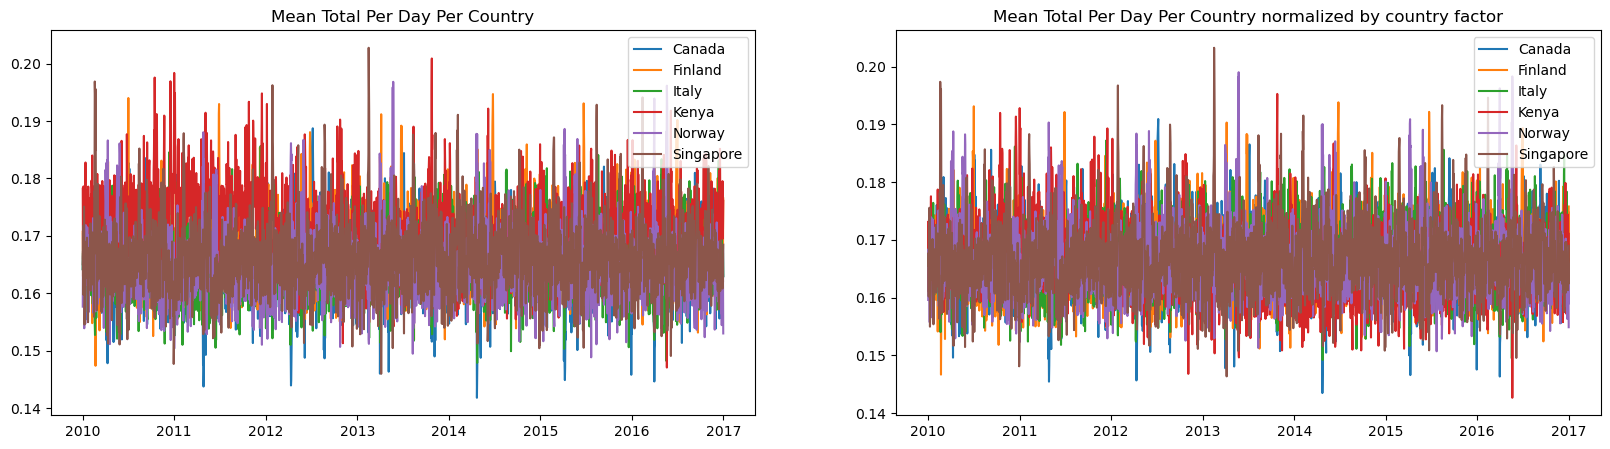

In [33]:
df['ratio'] = df['store_factor'] * df['gdp_factor'] * df['product_factor'] * df['day_of_week_factor'] * df['sincos_factor'] * df['trend_factor']
df['total'] = df['num_sold'] / df['ratio']

grouped_data = df[df['product'] == "Kaggle"].groupby(['date', 'country'])['total'].sum().reset_index()
total_per_day = df[df['product'] == "Kaggle"].groupby('date')['total'].sum().reset_index()
grouped_data = grouped_data.merge(total_per_day, on=['date'], suffixes=['', '_per_day'])
grouped_data = grouped_data[grouped_data['date'] < dt.datetime(2017, 1, 1)]

df['ratio'] = df['store_factor'] * df['gdp_factor'] * df['product_factor'] * df['day_of_week_factor'] * df['sincos_factor'] * df['trend_factor']
df['total'] = df['num_sold'] / df['ratio']

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

for country in df['country'].unique():
    country_data = grouped_data[grouped_data['country'] == country]
    axs[0].plot(country_data['date'], country_data['total'] / country_data['total_per_day'], '-', label=country)
axs[0].set_title('Mean Total Per Day Per Country')
axs[0].legend()

country_factor = df[(df['product'] == 'Kaggle')].groupby('country').total.sum().rename('country_factor')
country_factor = country_factor / country_factor.median()
df = df.drop('country_factor', axis=1, errors='ignore')
df = df.merge(country_factor, on='country')
df['ratio'] = df['store_factor'] * df['gdp_factor'] * df['product_factor'] * df['day_of_week_factor'] * df['sincos_factor'] * df['country_factor']
df['total'] = df['num_sold'] / df['ratio']

# Visualize the result
grouped_data = df[df['product'] == "Kaggle"].groupby(['date', 'country'])['total'].sum().reset_index()
total_per_day = df[df['product'] == "Kaggle"].groupby('date')['total'].sum().reset_index()
grouped_data = grouped_data.merge(total_per_day, on=['date'], suffixes=['', '_per_day'])
grouped_data = grouped_data[grouped_data['date'] < dt.datetime(2017, 1, 1)]

for country in df['country'].unique():
    country_data = grouped_data[grouped_data['country'] == country]
    axs[1].plot(country_data['date'], country_data['total'] / country_data['total_per_day'], '-', label=country)
axs[1].set_title('Mean Total Per Day Per Country normalized by country factor')
axs[1].legend()

## Holiday Factor

In [28]:
# Define the years and countries
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
countries = df['country'].unique()
# Initialize an empty list to hold DataFrames
dfs = []
# Generate holidays for each country and year
for year in years:
    for country in countries:
        for date, holiday_name in sorted(holidays.CountryHoliday(country, years=year).items()):

            df_0 = pd.DataFrame({"date": [date], "country": [
                country]})
            dfs.append(df_0)

# Concatenate all the DataFrames
df_holidays = pd.concat(dfs, ignore_index=True)
# Convert 'date' column to datetime
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_holidays['tmp'] = 1

In [29]:
for column in df.columns:
    if 'holiday_' in column:
        df = df.drop(column, axis=1)

In [30]:
# holidays
holidays_columns = []
for i in range(0, 10):
    column = 'holiday_{}'.format(i)
    shifted = df_holidays.rename(columns={'tmp': column})
    shifted['date'] = shifted['date'] + dt.timedelta(days=i)
    df = pd.merge(df, shifted, on=['country', 'date'], how='left')
    df[column].fillna(0, inplace=True)
    df[column] = df[column]
    holidays_columns.append(column)

C:\Users\yashs\AppData\Local\Temp\ipykernel_15368\1702739955.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(0, inplace=True)
C:\Users\yashs\AppData\Local\Temp\ipykernel_15368\1702739955.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

Text(0.5, 1.0, 'Total Over Time')

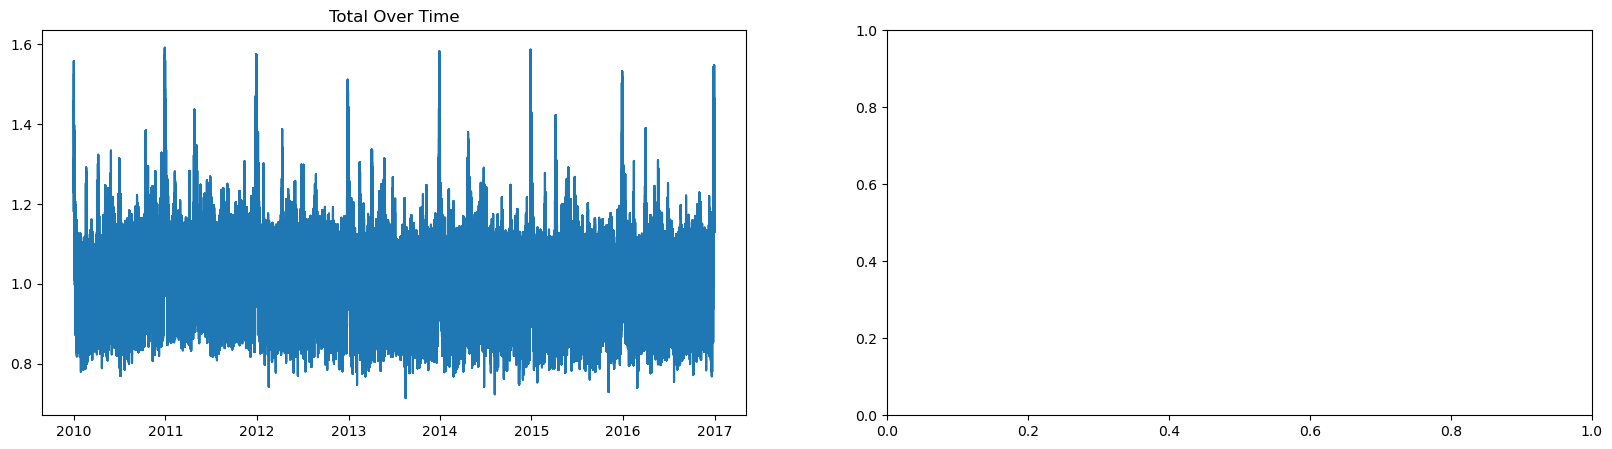

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

df['ratio'] = df['store_factor'] * df['gdp_factor'] * df['product_factor'] * df['day_of_week_factor'] * df['sincos_factor'] * df['country_factor'] * df['trend_factor']
df['total'] = df['num_sold'] / df['ratio']

axs[0].plot(df['date'], df['total'], '-')
axs[0].set_title('Total Over Time')

# # fit linear model to total using holidays

# train = df[(df['date'] > dt.datetime(2012, 12, 31)) & (df['date'] < dt.datetime(2017, 1, 1))]
# X = train[holidays_columns]
# y = train['total']
# model = fit_mape_linear_model(X, y)

# df['holiday_factor'] = model.predict(df[holidays_columns])

# df['ratio'] = df['store_factor'] * df['gdp_factor'] * df['product_factor'] * df['day_of_week_factor'] * df['sincos_factor'] * df['country_factor'] * df['holiday_factor'] * df['trend_factor']
# df['total'] = df['num_sold'] / df['ratio']

# axs[1].plot(df['date'], df['total'], '-')
# axs[1].set_title('Total Over Time normalized by holiday factor')

## New Years Factor

In [22]:
new_years_columns = []
for day in range(25, 32):
    column = 'day_12_{}'.format(day)
    df[column] = ((df['date'].dt.month == 12) & (df['date'].dt.day == day)).astype(float)
    new_years_columns.append(column)
for day in range(1, 11):
    column = 'day_1_{}'.format(day)
    df[column] = ((df['date'].dt.month == 1) & (df['date'].dt.day  == day)).astype(float)
    new_years_columns.append(column)

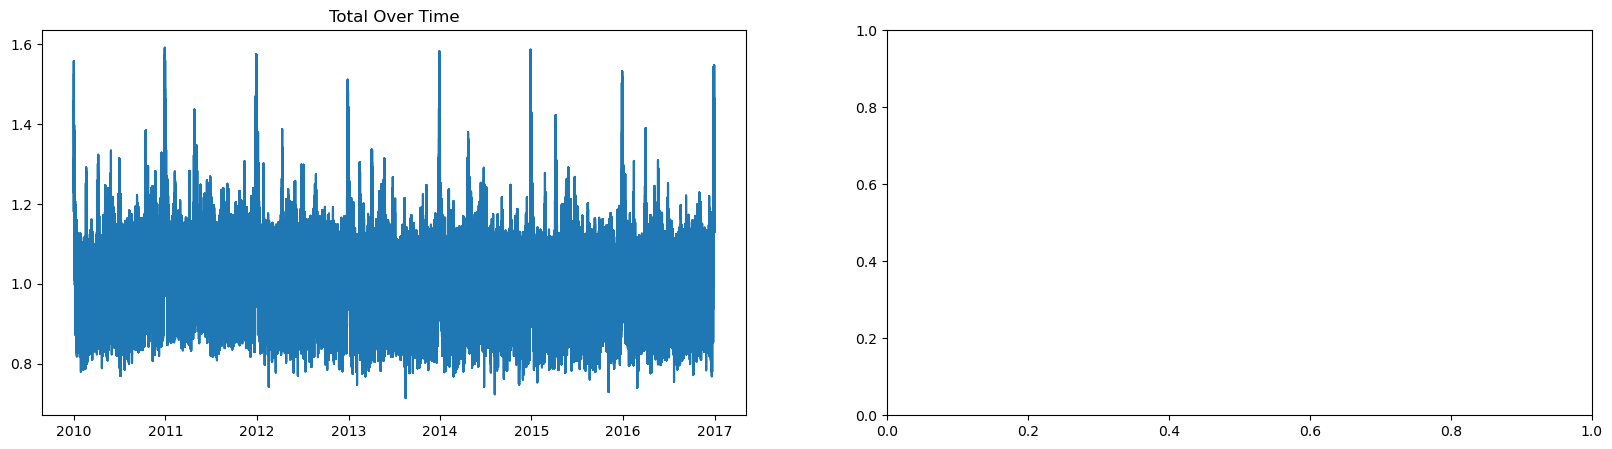

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

df['ratio'] = df['store_factor'] * df['gdp_factor'] * df['product_factor'] * df['day_of_week_factor'] * df['sincos_factor'] * df['country_factor'] * df['trend_factor']
df['total'] = df['num_sold'] / df['ratio']

axs[0].plot(df['date'], df['total'], '-')
axs[0].set_title('Total Over Time')

train = df[(df['date'] > dt.datetime(2012, 12, 31)) & (df['date'] < dt.datetime(2017, 1, 1))]
X = train[new_years_columns]
y = train['total']
model = fit_mape_linear_model(X, y)

# df['new_years_factor'] = model.predict(df[new_years_columns])

# df['ratio'] = df['store_factor'] * df['gdp_factor'] * df['product_factor'] * df['day_of_week_factor'] * df['sincos_factor'] * df['country_factor'] * df['new_years_factor'] * df['trend_factor']
# df['total'] = df['num_sold'] / df['ratio']

# axs[1].plot(df['date'], df['total'], '-')
# axs[1].set_title('Total Over Time normalized by new years factor')

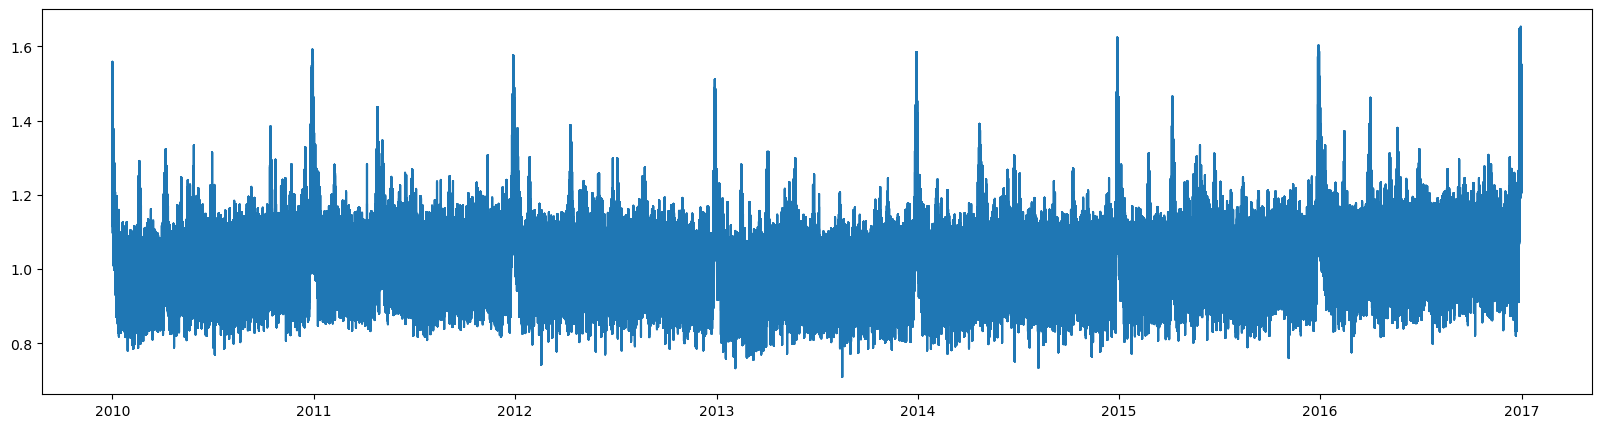

In [41]:
df['ratio'] = df['country_factor'] * df['store_factor'] * df['gdp_factor'] * df['product_factor'] * df['day_of_week_factor'] * df['sincos_factor'] #* df['holiday_factor'] * df['new_years_factor']
df['total'] = df['num_sold'] / df['ratio']

# Multiplying the predictions by 1.06 seems to improve the public LB score.
# I'm not entirely sure why, but I suspect it has to do with the fact that the model is off by ~6% by 2017 (as shown in the right plot of the sincos section above).
const_factor = df['total'].median() * 1.06

df['prediction'] = df['ratio'] * const_factor 

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(df['date'], df['total'])

In [42]:
from sklearn.metrics import mean_absolute_percentage_error

mape_train = mean_absolute_percentage_error(df[(df['date'] < dt.datetime(2017, 1, 1)) & (~pd.isna(df.num_sold))].num_sold, df[(df['date'] < dt.datetime(2017, 1, 1)) & (~pd.isna(df.num_sold))].prediction)

print(f'{mape_train=}')


mape_train=0.07672107518590722
